In [ ]:
"""
데이터셋
Crema, Ravdess, Tess, Savee

Positive: happiness - 2323
Neutral: neutral, calmness - 1895
Negative: anger, sadness - 3846
"""

In [1]:
import numpy as np
import time
from tqdm import tqdm
import os
import librosa
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical
from keras.models import load_model, Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dense, Dropout

C:\Users\DeepLearning_5\Anaconda3\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.24.3) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
base_dir = 'dataset'

n_mfcc = 128
num_rows = 150
num_columns = 130
input_shape = (num_rows, num_columns, 1)

n_epochs = 150
batch_size = None
split_val = True

model_save_path = 'saved_models/model.h5'

In [3]:
def load_feature_tuple(file_name):
    y, sr = librosa.load(file_name, mono=True)

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)

    return mfcc, spectral_centroid, spectral_rolloff

In [4]:
def pad_feature_width(feature, feature_width):
    diff = feature_width - feature.shape[1]
    if diff > 0:
        return np.pad(feature, pad_width=((0, 0), (0, diff)), mode='constant')
    elif diff < 0:
        return np.delete(feature, np.arange(feature_width, feature.shape[1]), axis=1)
    return feature

In [5]:
def extract_feature(file_name, feature_width):
    image = np.concatenate(load_feature_tuple(file_name), axis=0)
    image = pad_feature_width(image, feature_width)
    image = np.transpose(image)
    return image

In [6]:
def fetch_dataset(dir_path, label):
    _features = np.empty((0, ) + input_shape)
    for file_name in tqdm(os.listdir(dir_path)):
        file_path = os.path.join(dir_path, file_name)
        feature = extract_feature(file_path, input_shape[0]).reshape((1, ) + input_shape)
        _features = np.append(_features, feature, axis=0)

    _labels = np.full((_features.shape[0], ), label)

    return _features, _labels

# 데이터셋 가져오기

In [7]:
start_time = time.time()

positive_features, positive_labels = fetch_dataset(base_dir + '/positive', 'POSITIVE')
neutral_features, neutral_labels = fetch_dataset(base_dir + '/neutral', 'NEUTRAL')
negative_features, negative_labels = fetch_dataset(base_dir + '/negative', 'NEGATIVE')

print('elapsed time fetching dataset (sec):', time.time() - start_time)

100%|██████████████████████████████████████████████████████████████████████████████| 3846/3846 [16:04<00:00,  3.99it/s]

elapsed time fetching dataset (sec): 1729.2398381233215


In [8]:
features = np.concatenate((positive_features, neutral_features, negative_features), axis=0)
labels = np.concatenate((positive_labels, neutral_labels, negative_labels), axis=0)

print('features shape:', features.shape)
print('labels shape before encoding:', labels.shape)

features shape: (8064, 150, 130, 1)
labels shape before encoding: (8064,)


In [9]:
le = LabelEncoder()
labels = to_categorical(le.fit_transform(labels))
print('labels shape after encoding:', labels.shape)
print('label encoder classes:', le.classes_)

labels shape after encoding: (8064, 3)
label encoder classes: ['NEGATIVE' 'NEUTRAL' 'POSITIVE']


In [10]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)

# 학습

In [11]:
model = Sequential()

# Block 1
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2'))
model.add(MaxPooling2D(2, strides=(2, 2), name='block1_pool'))

# Block 2
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2'))
model.add(MaxPooling2D(2, strides=(2, 2), name='block2_pool'))

# Block 3
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3'))
model.add(MaxPooling2D(2, strides=(2, 2), name='block3_pool'))

# Block 4
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3'))
model.add(MaxPooling2D(2, strides=(2, 2), name='block4_pool'))

# Block 5
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3'))
model.add(MaxPooling2D(2, strides=(2, 2), name='block5_pool'))

model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 150, 130, 64)      640       
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 130, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 65, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 65, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 65, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 32, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 37, 32, 256)       2

In [12]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [13]:
if split_val:
    validation_split = 0.25
else:
    validation_split = 0.0

In [14]:
start_time = time.time()

hist = model.fit(x_train, y_train,
                 epochs=n_epochs,
                 batch_size=batch_size,
                 validation_split=validation_split,
                 shuffle=True,
                 verbose=1)

print('elapsed time training dataset (sec):', time.time() - start_time)

model.save(model_save_path)

Epoch 1/150
152/152 [==============================] - 23s 133ms/step - loss: 3.9724 - accuracy: 0.5110 - val_loss: 8497.4355 - val_accuracy: 0.4476
Epoch 2/150
152/152 [==============================] - 19s 124ms/step - loss: 1.2621 - accuracy: 0.6013 - val_loss: 187.5041 - val_accuracy: 0.5387
Epoch 3/150
152/152 [==============================] - 19s 125ms/step - loss: 0.7894 - accuracy: 0.6496 - val_loss: 5.6234 - val_accuracy: 0.6200
Epoch 4/150
152/152 [==============================] - 19s 125ms/step - loss: 0.7078 - accuracy: 0.6621 - val_loss: 42.5531 - val_accuracy: 0.6665
Epoch 5/150
152/152 [==============================] - 19s 125ms/step - loss: 0.6605 - accuracy: 0.6840 - val_loss: 69.4822 - val_accuracy: 0.6863
Epoch 6/150
152/152 [==============================] - 19s 125ms/step - loss: 0.6703 - accuracy: 0.6776 - val_loss: 3978.2727 - val_accuracy: 0.6826
Epoch 7/150
152/152 [==============================] - 19s 124ms/step - loss: 0.6619 - accuracy: 0.6846 - val_loss

Epoch 56/150
152/152 [==============================] - 19s 125ms/step - loss: 0.2557 - accuracy: 0.8993 - val_loss: 200274.2188 - val_accuracy: 0.6776
Epoch 57/150
152/152 [==============================] - 19s 125ms/step - loss: 0.2649 - accuracy: 0.8954 - val_loss: 9126626.0000 - val_accuracy: 0.6677
Epoch 58/150
152/152 [==============================] - 19s 125ms/step - loss: 0.2767 - accuracy: 0.8909 - val_loss: 0.9149 - val_accuracy: 0.7719
Epoch 59/150
152/152 [==============================] - 19s 125ms/step - loss: 0.2533 - accuracy: 0.9012 - val_loss: 38662204.0000 - val_accuracy: 0.7241
Epoch 60/150
152/152 [==============================] - 19s 125ms/step - loss: 0.2241 - accuracy: 0.9122 - val_loss: 40194060.0000 - val_accuracy: 0.7409
Epoch 61/150
152/152 [==============================] - 19s 124ms/step - loss: 0.2162 - accuracy: 0.9144 - val_loss: 16697241.0000 - val_accuracy: 0.6162
Epoch 62/150
152/152 [==============================] - 19s 124ms/step - loss: 0.2196 

Epoch 110/150
152/152 [==============================] - 19s 125ms/step - loss: 0.1527 - accuracy: 0.9458 - val_loss: 3802231.2500 - val_accuracy: 0.7297
Epoch 111/150
152/152 [==============================] - 19s 125ms/step - loss: 0.0871 - accuracy: 0.9678 - val_loss: 3421369600.0000 - val_accuracy: 0.7905
Epoch 112/150
152/152 [==============================] - 19s 125ms/step - loss: 0.0615 - accuracy: 0.9785 - val_loss: 23111837696.0000 - val_accuracy: 0.7359
Epoch 113/150
152/152 [==============================] - 19s 124ms/step - loss: 0.0455 - accuracy: 0.9843 - val_loss: 1.6384 - val_accuracy: 0.7750
Epoch 114/150
152/152 [==============================] - 19s 125ms/step - loss: 0.0389 - accuracy: 0.9862 - val_loss: 11240.2852 - val_accuracy: 0.7458
Epoch 115/150
152/152 [==============================] - 19s 125ms/step - loss: 0.0595 - accuracy: 0.9806 - val_loss: 9.4530 - val_accuracy: 0.7818
Epoch 116/150
152/152 [==============================] - 19s 124ms/step - loss: 0.0

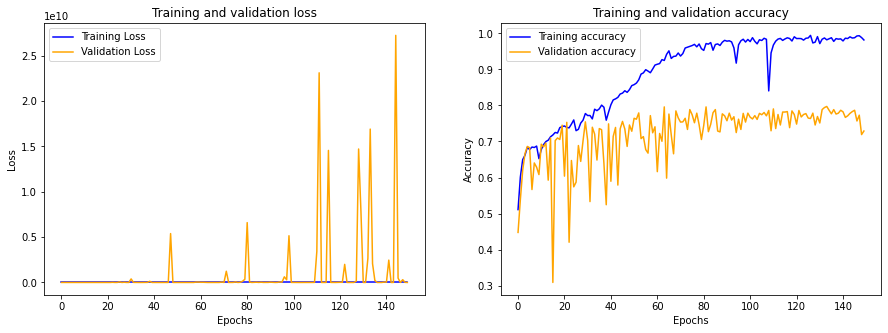

In [15]:
history_dict = hist.history

loss_values = history_dict['loss']
acc_values = history_dict['accuracy']
if split_val:
    val_loss_values = history_dict['val_loss']
    val_acc_values = history_dict['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(loss_values, 'blue', label='Training Loss')
if split_val:
    ax1.plot(val_loss_values, 'orange', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(acc_values, 'blue', label='Training accuracy')
if split_val:
    ax2.plot(val_acc_values, 'orange', label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

In [16]:
loss, accuracy = model.evaluate(x_test, y_test)
print('test loss:', loss)
print('test accuracy:', accuracy)

51/51 [==============================] - 2s 38ms/step - loss: 62963328.0000 - accuracy: 0.7328
test loss: 62963328.0
test accuracy: 0.7327960133552551


# 파일 테스트

In [ ]:
test_file_name = 'dataset/negative/1001_DFA_ANG_XX.wav'

In [ ]:
prediction_feature = extract_feature(test_file_name, input_shape[0]).reshape((1, ) + input_shape)
model = load_model(model_save_path)

predicted_proba = model.predict(prediction_feature)[0]
predicted_class = np.argmax(predicted_proba)

print('classification result:', le.classes_[predicted_class])